In [1]:
%pylab inline
%config InlineBackend.figure_format = 'retina'

Populating the interactive namespace from numpy and matplotlib


In [33]:
import arviz as az
import gbfit # To have access to waveform tools; this is safe to import as a module
from kde_contour import kdeplot_2d_clevels
import pandas as pd
import scipy.stats as ss
import seaborn as sns
import warnings

sns.set_context('notebook')
sns.set_palette('colorblind')
sns.set_style('ticks')

In [3]:
fit = az.from_netcdf('testinj2.nc')
inj = genfromtxt('testinj2.dat', names=True)

Tobs = fit.constant_data.Tobs.values[0]
hbin = int(round(fit.constant_data.hbin.values[0]))

In [10]:
good_chains = [1,2]

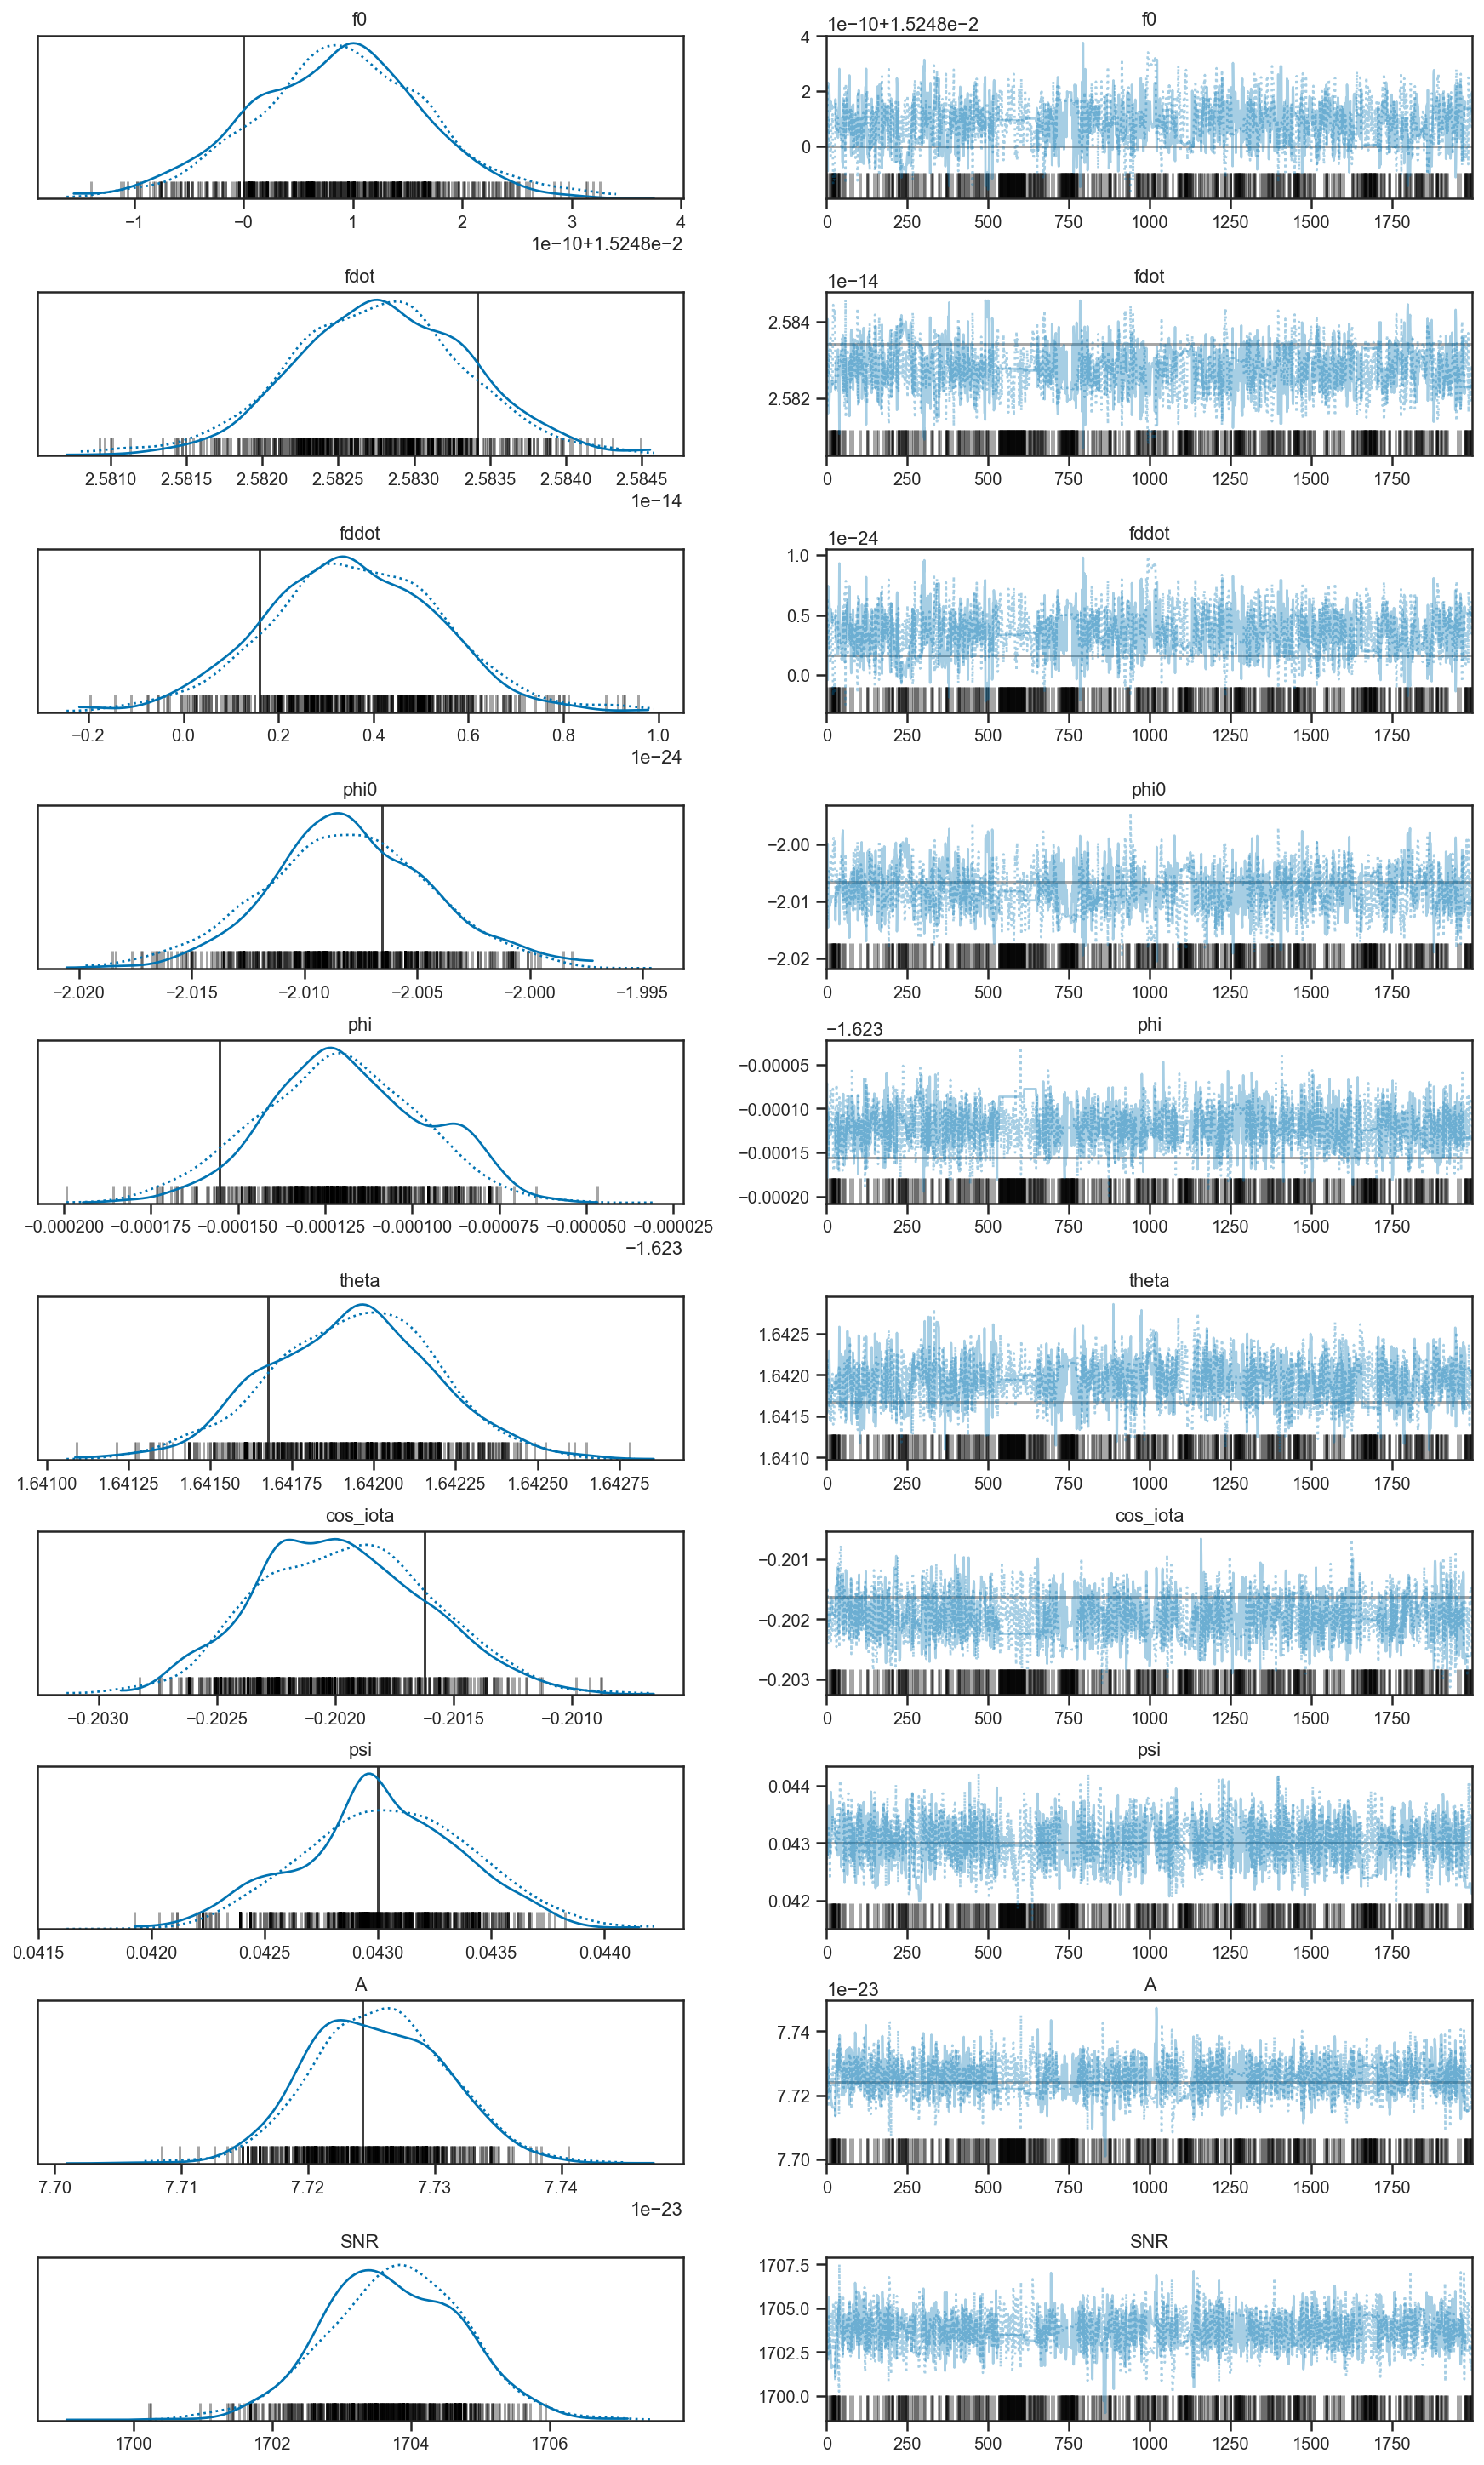

In [11]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    az.plot_trace(fit, compact=True, var_names=['f0', 'fdot', 'fddot', 'phi0', 'phi', 'theta', 'cos_iota', 'psi', 'A', 'SNR'],
                  lines=(('f0', {}, inj['f0']),
                         ('fdot', {}, inj['fdot']),
                         ('fddot', {}, inj['fddot']),
                         ('phi0', {}, inj['phi0']),
                         ('phi', {}, inj['phi']),
                         ('theta', {}, inj['theta']),
                         ('cos_iota', {}, inj['cos_iota']),
                         ('psi', {}, inj['psi']),
                         ('A', {}, inj['A'])),
                  coords={'chain': good_chains})

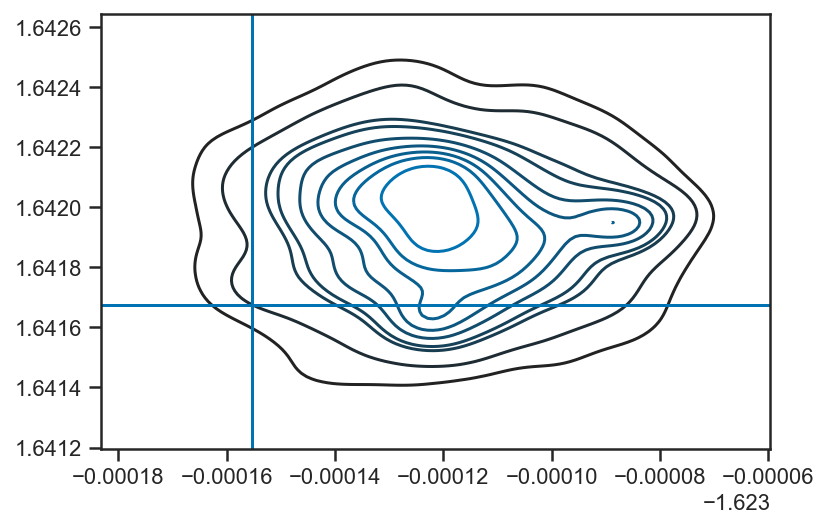

In [41]:
kdeplot_2d_clevels(fit.posterior.phi[good_chains,:].values.flatten(),
                   fit.posterior.theta[good_chains,:].values.flatten())
axhline(inj['theta'])
axvline(inj['phi'])

/Users/wfarr/Code/GBPyro/kde_contour.py:28: UserWarning: The following kwargs were not used by contour: 'label', 'color'
  ax.contour(XS, YS, ZS, levels=l, **kwargs)


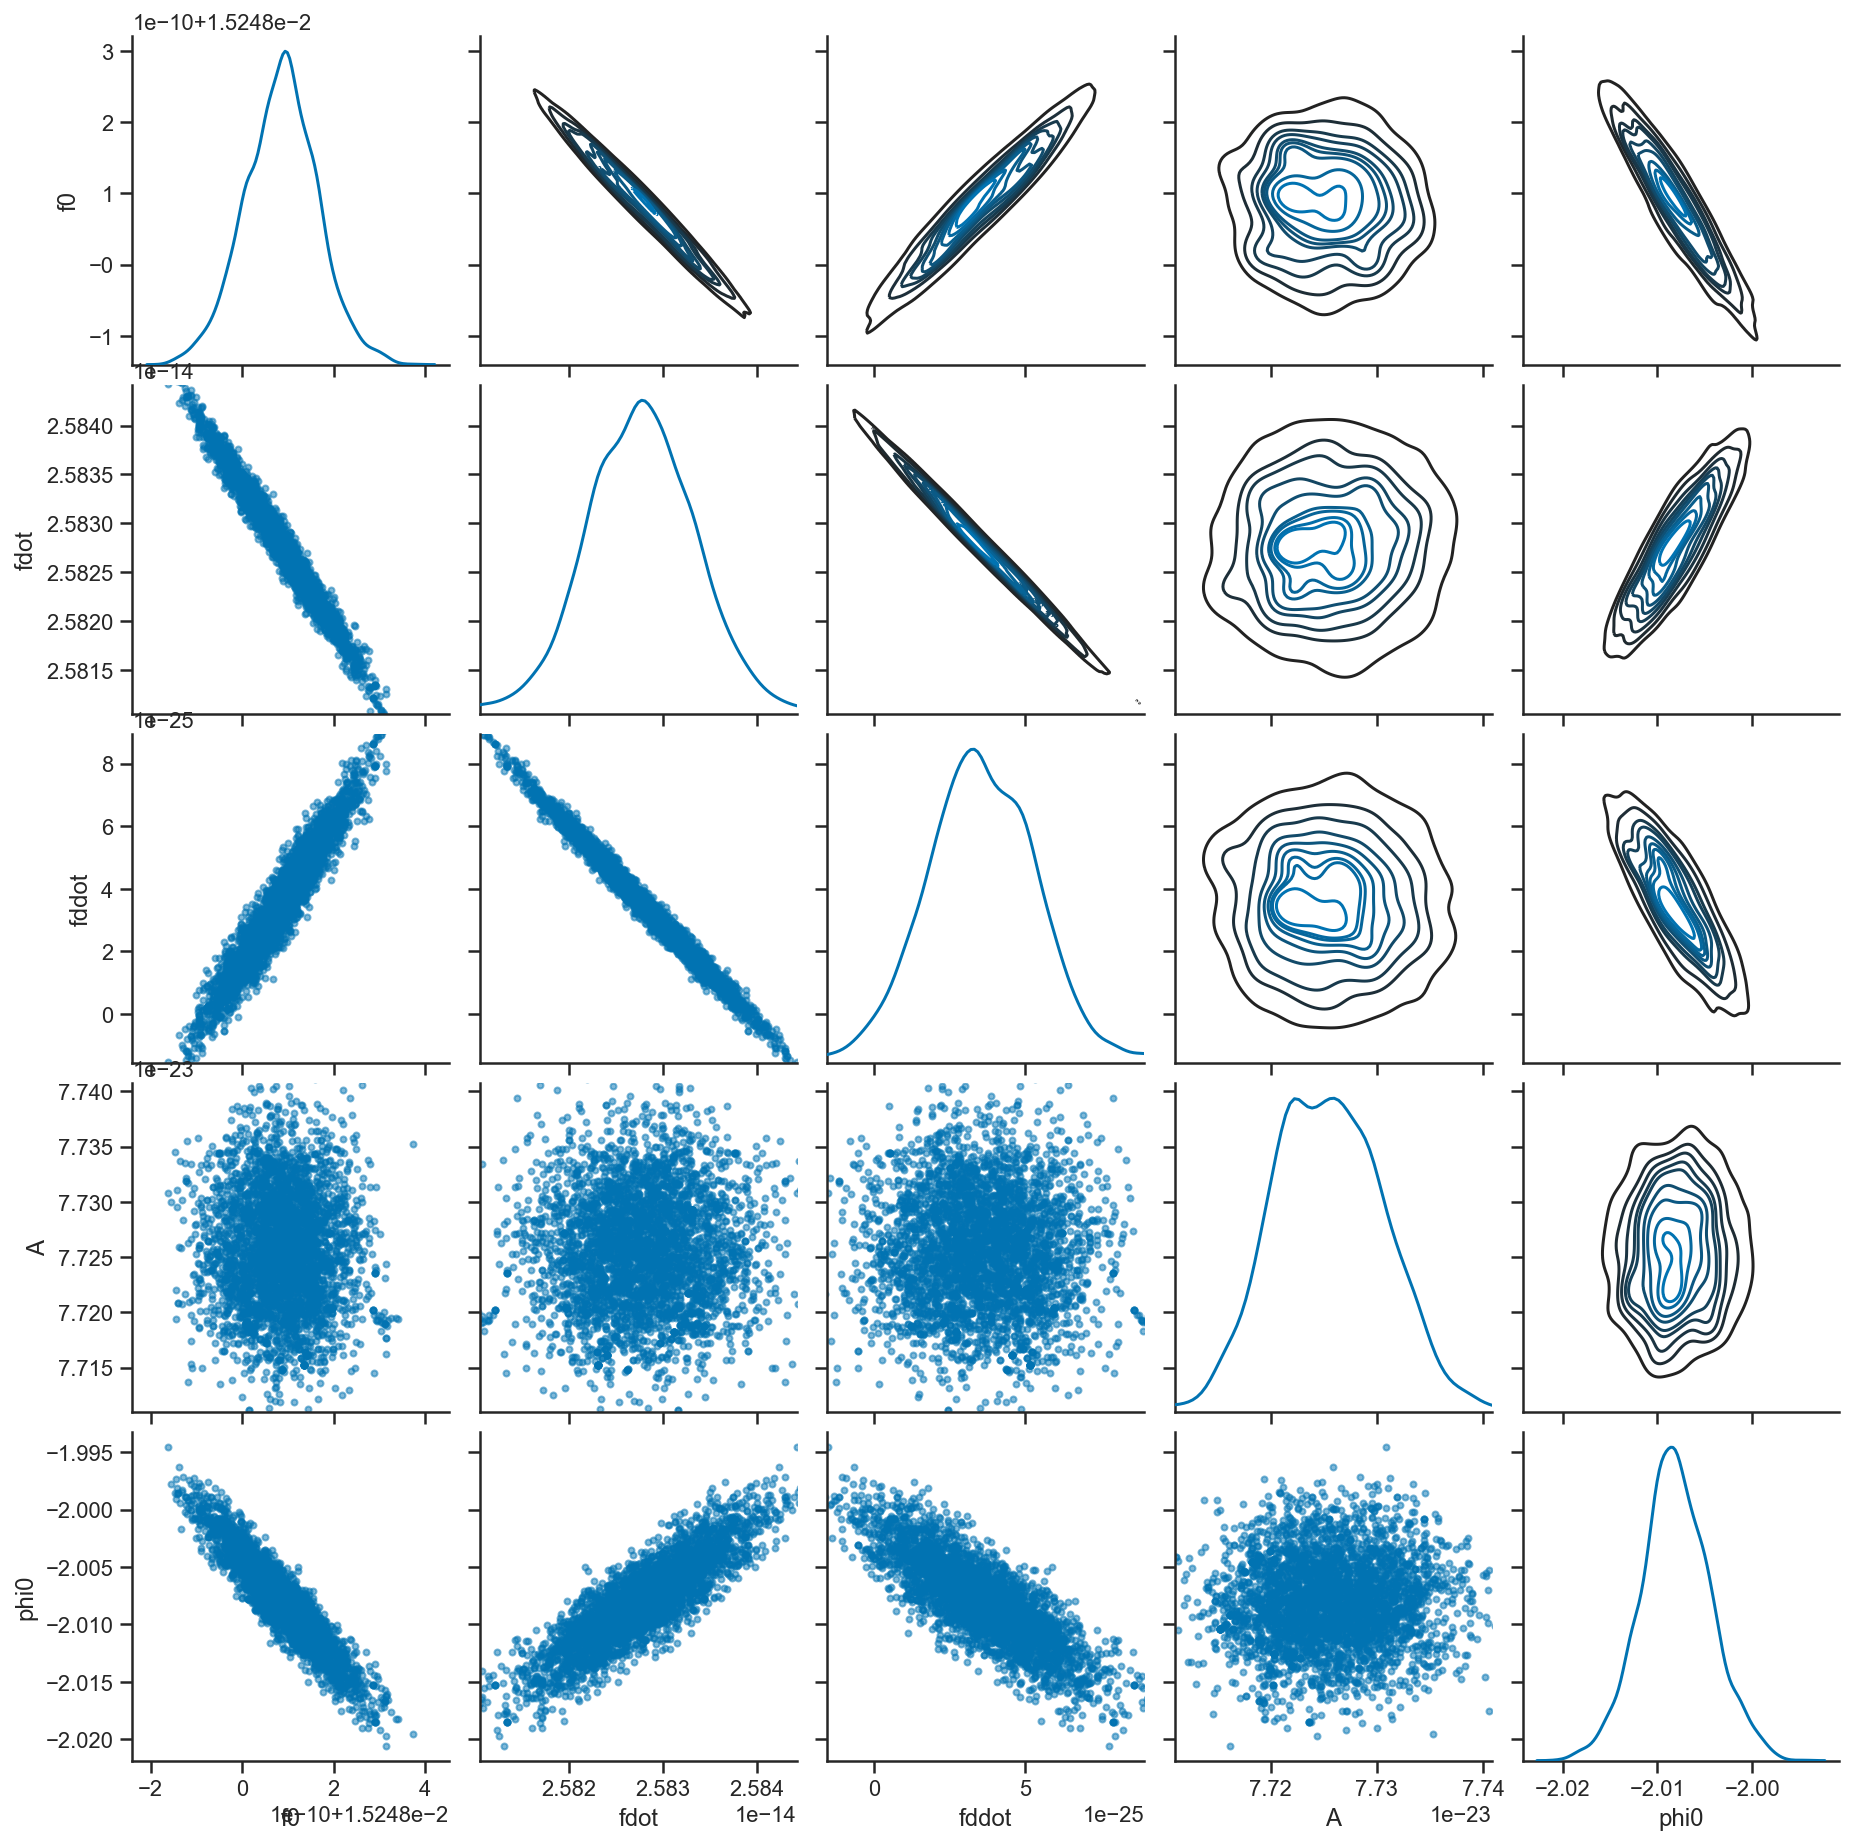

In [13]:
m = {}
for k in ['f0', 'fdot', 'fddot', 'A', 'phi0']:
    m[k] = fit.posterior[k].values[good_chains,:].flatten()
df = pd.DataFrame(m)
g = sns.PairGrid(df, diag_sharey=False)
g.map_diag(sns.kdeplot)
g.map_upper(kdeplot_2d_clevels)
g.map_lower(scatter, marker='.', alpha=0.5)

Here is a comparison between the model and the data, in the real part of the $A$ channel.  The residuals look reasonable by eye, but their distribution is not $N\left(0, \sigma_A\right)$, so there is still something left in the data that the model has not yet accessed.

Text(0, 0.5, '$p\\left( \\mathcal{R} \\delta A \\right)$')

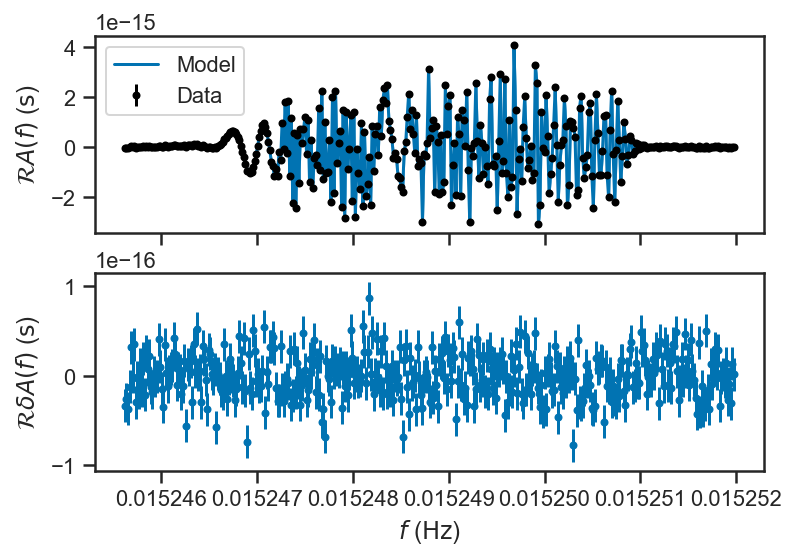

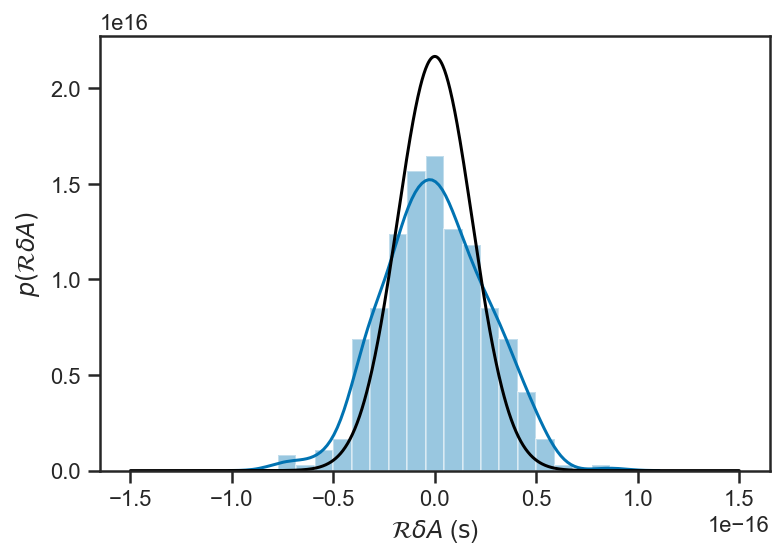

In [38]:
Nplot = 200
fig, (ax1, ax2) = subplots(nrows=2, ncols=1, sharex=True)

Ad = concatenate((fit.constant_data.A_re_data.values[-Nplot:], fit.constant_data.A_re_data.values[:Nplot]))
A = concatenate((fit.posterior.A_re.values[good_chains,:,-Nplot:], fit.posterior.A_re.values[good_chains,:,:Nplot]), axis=2)

fs = arange(-Nplot, Nplot)/Tobs + hbin/Tobs

l, = ax1.plot(fs, median(A, axis=(0,1)), label='Model')
ax1.fill_between(fs, percentile(A, 84, axis=(0,1)), percentile(A, 16, axis=(0,1)), alpha=0.25, color=l.get_color())
ax1.fill_between(fs, percentile(A, 97.5, axis=(0,1)), percentile(A, 2.5, axis=(0,1)), alpha=0.25, color=l.get_color())

sigma_A = sqrt(2*pi*1e7*gbfit.Sn(1e-3)/4)
ax1.errorbar(fs, Ad, yerr=sigma_A, color='k', fmt='.', label='Data')

ax2.errorbar(fs, Ad - mean(A, axis=(0,1)), yerr=sigma_A, fmt='.', color=l.get_color())

ax1.legend(loc='upper left')
ax1.set_ylabel(r'$\mathcal{R} A(f)$ ($\mathrm{s}$)')
ax2.set_ylabel(r'$\mathcal{R} \delta A(f)$ ($\mathrm{s}$)')
ax2.set_xlabel(r'$f$ ($\mathrm{Hz}$)')

figure()
sns.distplot(Ad-mean(A, axis=(0,1)))
xs = linspace(-1.5e-16, 1.5e-16, 1024)
plot(xs, ss.norm(loc=0, scale=sigma_A).pdf(xs), color='k')
xlabel(r'$\mathcal{R} \delta A$ ($\mathrm{s}$)')
ylabel(r'$p\left( \mathcal{R} \delta A \right)$')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12fbc89d0>,
      dtype=object)

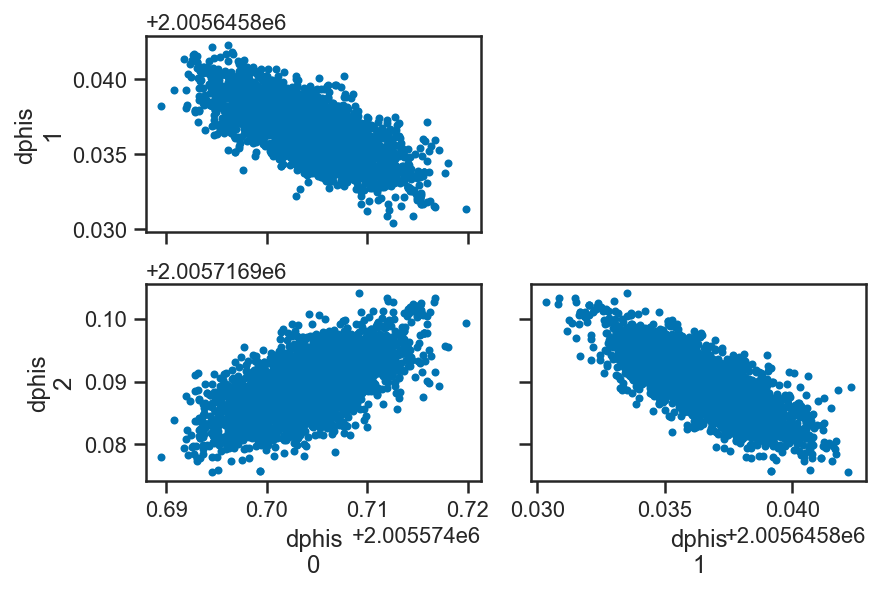

In [39]:
az.plot_pair(fit, var_names=['dphis'], coords={'chain': good_chains})

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x120655c50>,
      dtype=object)

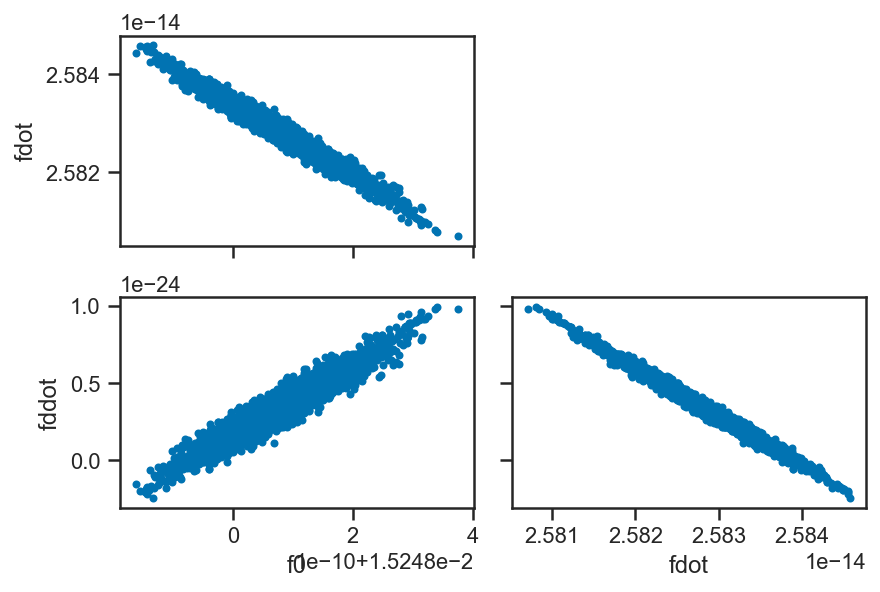

In [16]:
az.plot_pair(fit, var_names=['f0', 'fdot', 'fddot'], coords={'chain': good_chains})

Text(0, 0.5, '$\\theta$')

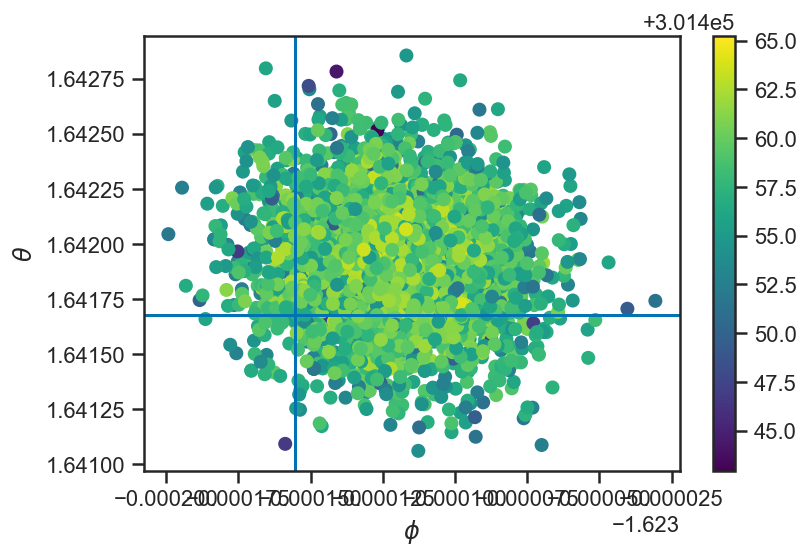

In [17]:
scatter(fit.posterior.phi.values[good_chains,:], fit.posterior.theta.values[good_chains,:], c=fit.sample_stats.lp.values[good_chains,:], cmap='viridis')
axhline(inj['theta'])
axvline(inj['phi'])
colorbar()

xlabel(r'$\phi$')
ylabel(r'$\theta$')

/Users/wfarr/Code/GBPyro/kde_contour.py:28: UserWarning: The following kwargs were not used by contour: 'label', 'color'
  ax.contour(XS, YS, ZS, levels=l, **kwargs)


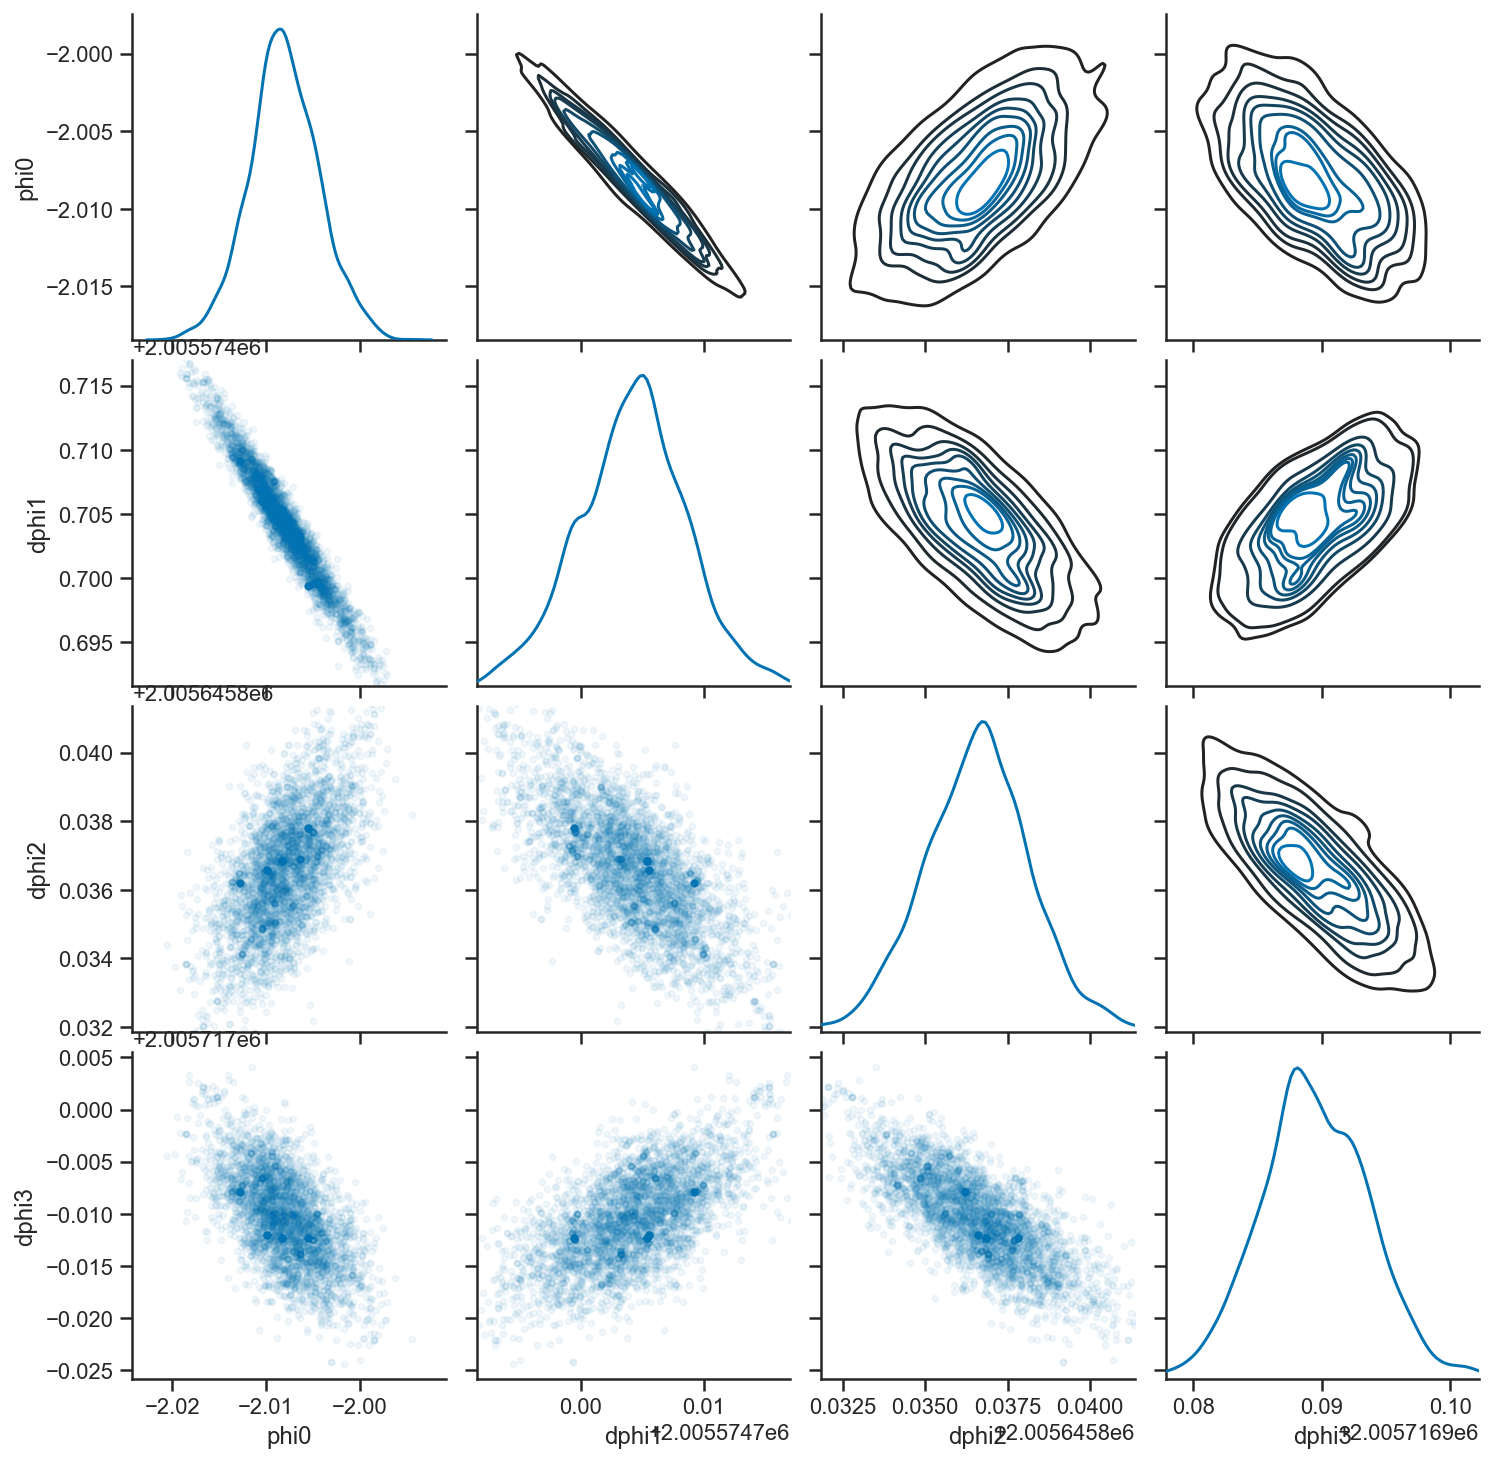

In [62]:
d = {}
d['phi0'] = fit.posterior.phi0[good_chains,:].values.flatten()
for i in range(3):
    d['dphi{:d}'.format(i+1)] = fit.posterior.dphis[good_chains,:,i].values.flatten()
d = pd.DataFrame(d)
g = sns.PairGrid(d, diag_sharey=False)

g.map_diag(sns.kdeplot)
g.map_upper(kdeplot_2d_clevels)
g.map_lower(scatter, marker='.', alpha=0.05)

/Users/wfarr/Code/GBPyro/kde_contour.py:28: UserWarning: The following kwargs were not used by contour: 'label', 'color'
  ax.contour(XS, YS, ZS, levels=l, **kwargs)


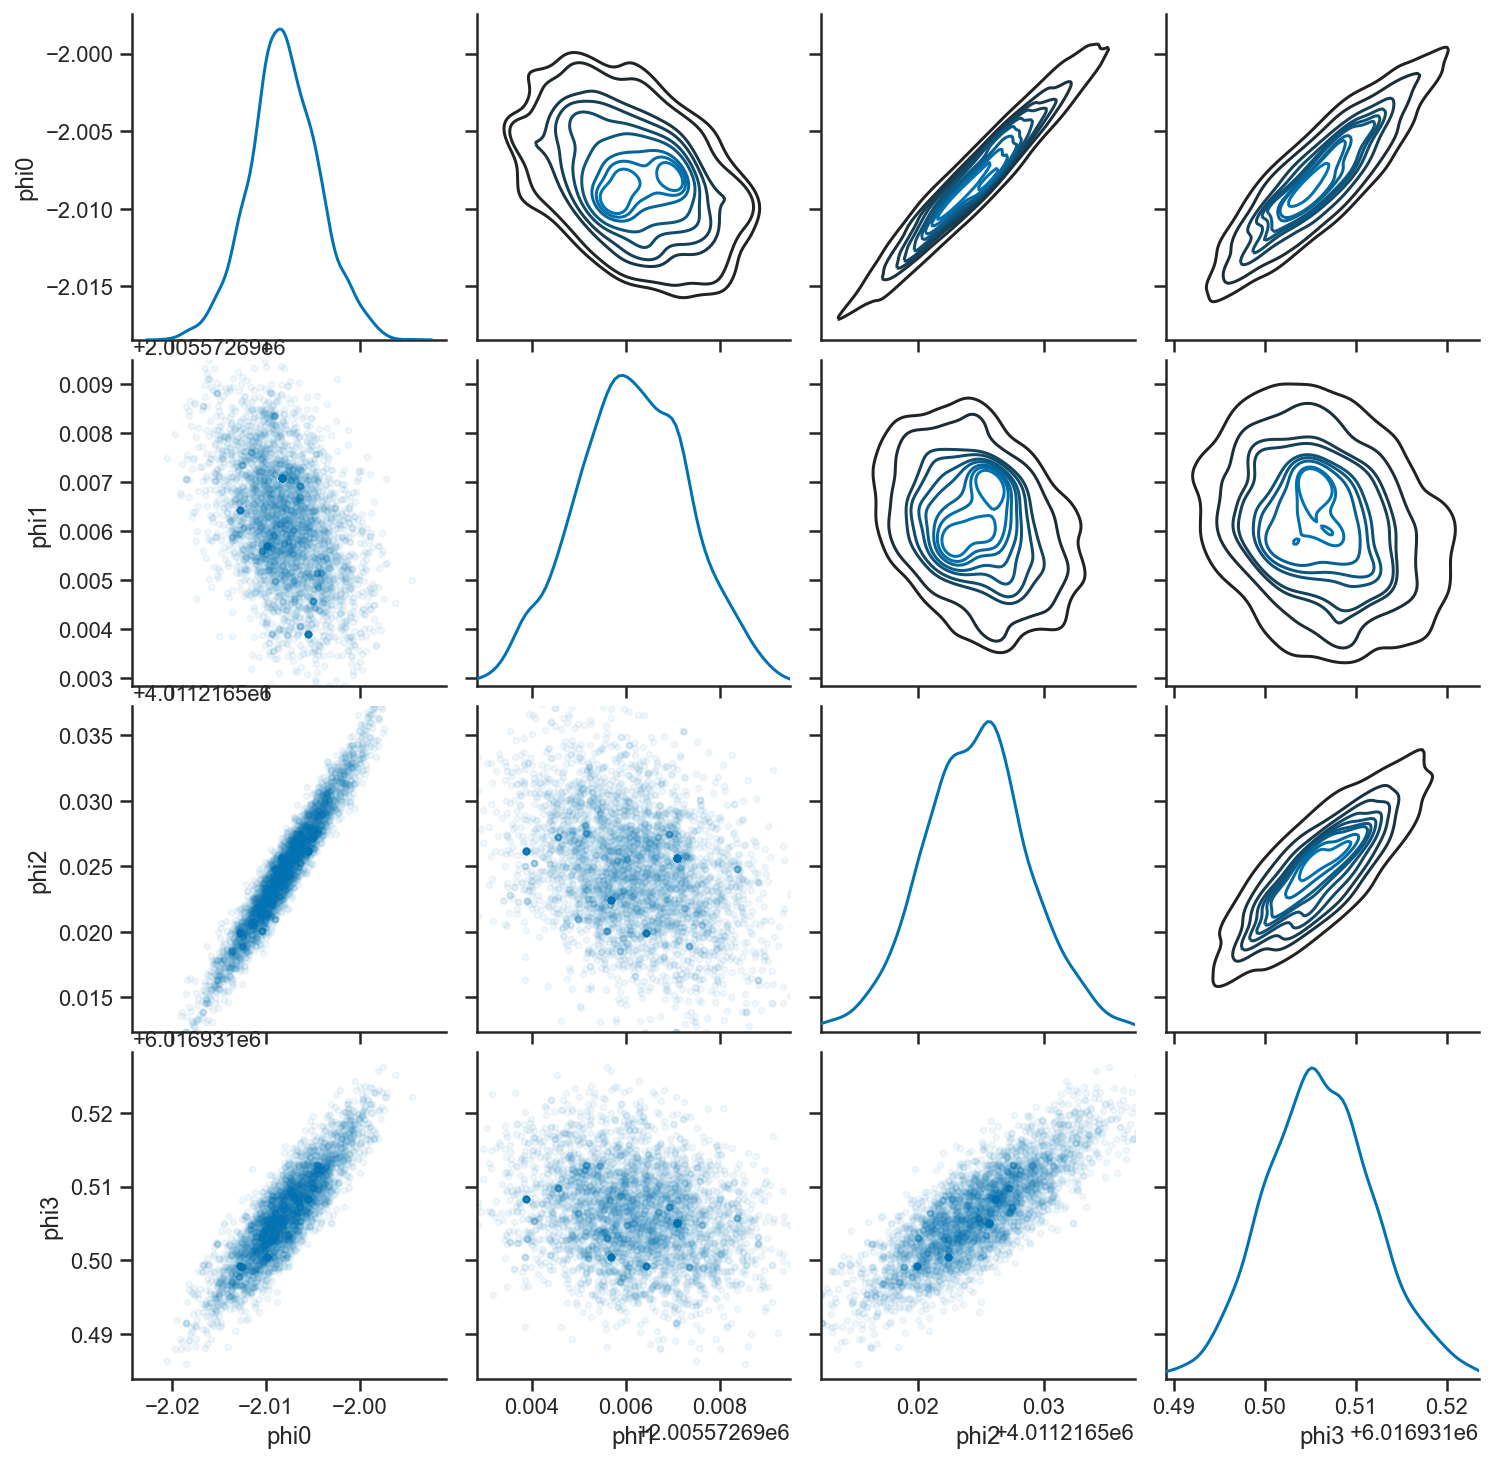

In [63]:
phis = cumsum(fit.posterior.phi0[good_chains,:].values[:,:,None] + fit.posterior.dphis[good_chains,:,:], axis=2)
d = {'phi0': fit.posterior.phi0[good_chains,:].values.flatten()}
for i in range(3):
    d['phi{:d}'.format(i+1)] = phis[:,:,i].values.flatten()
d = pd.DataFrame(d)
g = sns.PairGrid(d, diag_sharey=False)

g.map_diag(sns.kdeplot)
g.map_upper(kdeplot_2d_clevels)
g.map_lower(scatter, marker='.', alpha=0.05)

In [73]:
t = linspace(0, 1, 257)[:-1]
M = column_stack((ones_like(t), t, t*t, t*t*t))
u, s, vh = np.linalg.svd(M)

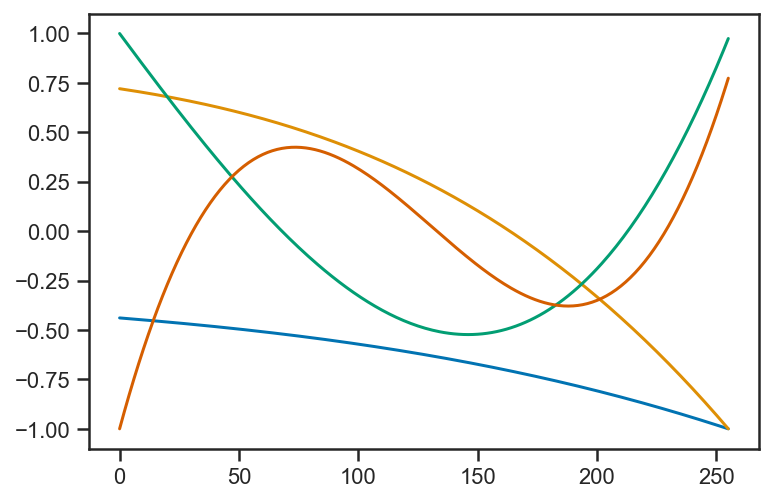

In [75]:
plot(u[:,0]/np.max(np.abs(u[:,0])))
plot(u[:,1]/np.max(np.abs(u[:,1])))
plot(u[:,2]/np.max(np.abs(u[:,2])))
plot(u[:,3]/np.max(np.abs(u[:,3])))

In [78]:
q, r = np.linalg.qr(column_stack((t*t*t/6, t*t/2, t, ones_like(t))))

In [79]:
r

array([[ -1.00101867,  -3.51044853,  -8.44161778, -10.57272596],
       [  0.        ,  -0.59336047,  -3.56717995,  -8.93551589],
       [  0.        ,   0.        ,  -0.92103249,  -6.92103208],
       [  0.        ,   0.        ,   0.        ,  -4.05873582]])

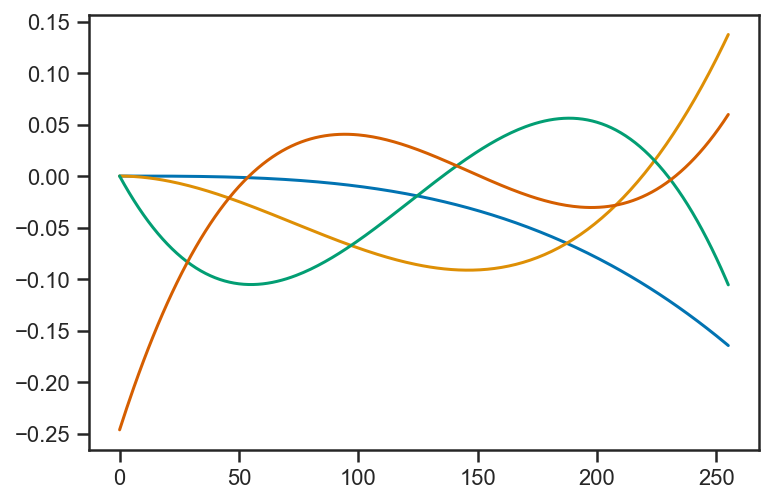

In [81]:
for i in range(4):
    plot(q[:,i])

In [90]:
t = linspace(-1, 1, 1024)
L = column_stack((ones_like(t), t, 0.5*(3*t*t - 1), 0.5*(5*t*t*t - 3*t)))

In [91]:
np.dot(L.T, L)

array([[ 1.02400000e+03,  2.84217094e-14,  1.00097752e+00,
        -9.23705556e-14],
       [ 2.84217094e-14,  3.42000652e+02, -2.84217094e-14,
         1.00228087e+00],
       [ 1.00097752e+00, -2.84217094e-14,  2.05601955e+02,
        -3.55271368e-14],
       [-9.23705556e-14,  1.00228087e+00, -3.55271368e-14,
         1.47146767e+02]])

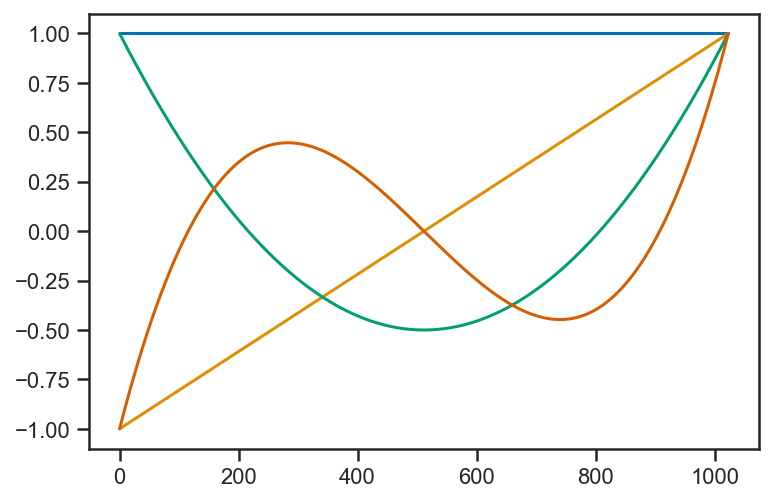

In [92]:
for i in range(4):
    plot(L[:,i])